# Recipe Site Traffic


Data validation:
The Data set has 892 rows and 8 columns. I have validated each columns and made appropriate changes to the dataset.

-recipe: They are integers and there are no missing values. Also every identifier is unique (no duplicates). No need for changes.

-calories: The datatype (float) is correct, but there are some missing values. Since the proportion of missing values barely exceeds 5% and the missing values correspond to missing values in three other columns, I have decided to drop the missing values.

-carbonhydrates: After dropping the rows with the missing calory values there were no missing values in this column. Data type was float as expected.

-sugar: After dropping the rows with the missing calory values there were no missing values in this column. Data type was float as expected.

-protein: After dropping the rows with the missing calory values there were no missing values in this column. Data type was float as expected.

-category: There were 11 categories instead of 10. The extra category was 'Chicken Breast'. I have decided to include these in the 'Chicken' category. The dtype of the column was object, so turned it into 'category' dtype.

-servings: The servings dtype was object instead of int. This was because it included two values '4 as snack' and '6 as snack'. I have decided to drop the rows with these values since they were negligable percentage of the dataset and these values would have been hard to integrate with the rest of the data (it is not clear if '4 as snack' should count as 4 serving, or somewhat less for example)

-high_traffic: It contained Null values and strings 'High'. I have converted the Null values into 'No' indicating 'No High traffic'. The dtype of the column is categorical.


In [2]:
import pandas as pd

url = "https://s3.amazonaws.com/talent-assets.datacamp.com/recipe_site_traffic_2212.csv"
df = pd.read_csv(url)
df.shape


(947, 8)

In [4]:
#validating data
#col: recipe
print(df['recipe'].dtype)
print(df['recipe'].duplicated().sum())
df['recipe'].isna().sum()

int64
0


0

In [5]:
#col: calories
print(df['calories'].dtype)
df['calories'].isna().sum()/len(df)*100
df[df['calories'].isna()]
df = df.dropna(subset = ['calories'])

float64


In [6]:
#col: carbohydrate
print(df['carbohydrate'].dtype)
df['carbohydrate'].isna().sum()/len(df)*100

float64


0.0

In [7]:
#col: sugar
print(df['sugar'].dtype)
df['sugar'].isna().sum()/len(df)*100


float64


0.0

In [8]:
#col: protein
print(df['protein'].dtype)
df['protein'].isna().sum()/len(df)*100

float64


0.0

In [9]:
#col: category
print(df['category'].dtype)

df.loc[df['category'] == 'Chicken Breast','category'] = 'Chicken'
print(set(df['category']))
df['category'] = df['category'].astype('category')
df['category'].isna().sum()/len(df)*100

object
{'Breakfast', 'Lunch/Snacks', 'Beverages', 'Dessert', 'Pork', 'Vegetable', 'Meat', 'One Dish Meal', 'Potato', 'Chicken'}


0.0

In [10]:
#col: servings

#checking what is included in the column other than integers
print(set(df['servings']))
print((len(df[df['servings']=='4 as a snack']) +len(df[df['servings']=='6 as a snack']))/len(df)*100)

#removing the rows with non-int value
df = df.drop(df[(df['servings'] == '4 as a snack') | (df['servings'] == '6 as a snack')].index)

df['servings'] = df['servings'].astype('int')
print(df['servings'].dtype)
df['servings'].isna().sum()/len(df)*100

{'6 as a snack', '4', '1', '4 as a snack', '6', '2'}
0.33519553072625696
int64


0.0

In [11]:
#col: high_traffic
df['high_traffic'].fillna('No', inplace = True)
df['high_traffic'].dtype

dtype('O')

# Explotory analysis

First I have analyzed the target variable. There is a slight class imbalance, I will consider that during my train-test split.

<AxesSubplot: xlabel='high_traffic', ylabel='count'>

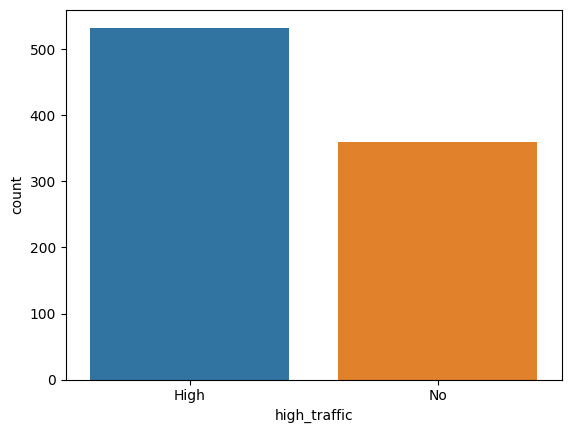

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data = df,x='high_traffic')

Next I have made histograms of the numerical classes. They are log-normally distributed, but for the models I will use, this is OK, so I have left them unchanged.

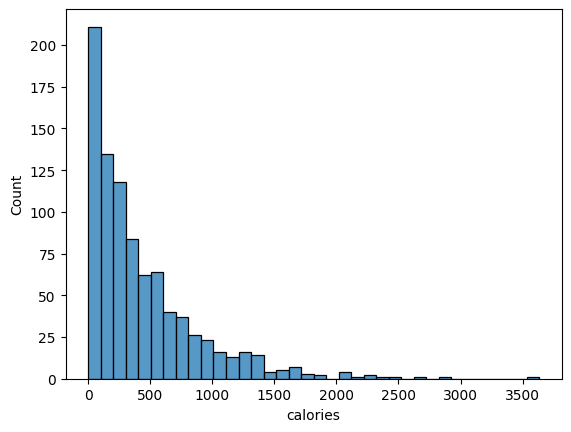

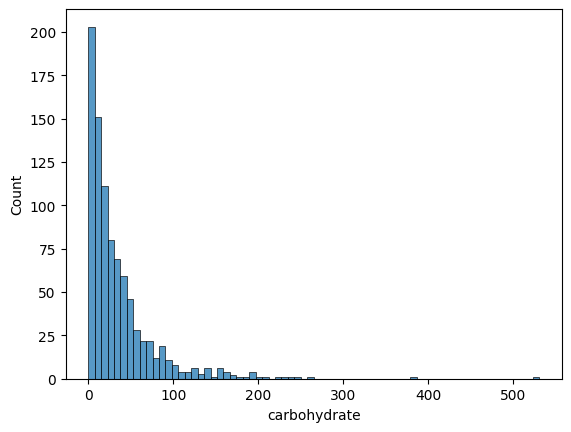

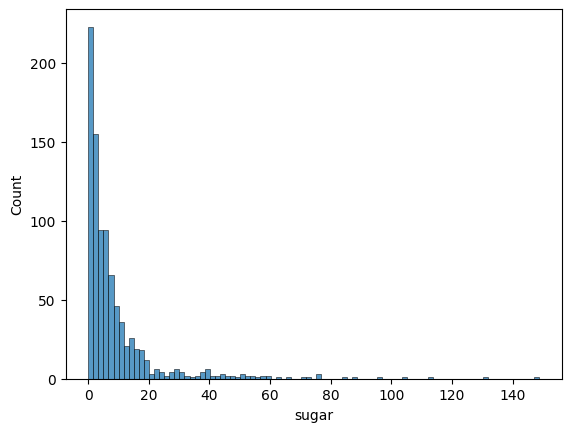

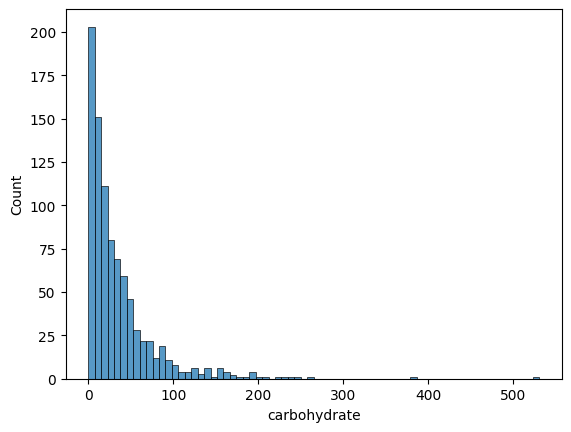

In [13]:
sns.histplot(data =df, x= 'calories')
plt.show()
sns.histplot(data =df, x= 'carbohydrate')
plt.show()
sns.histplot(data =df, x= 'sugar')
plt.show()
sns.histplot(data =df, x= 'carbohydrate')
plt.show()


import numpy as np



Next I explored the categorical variables. They are fairly similar. Recipes with 4 servings are more numerous, this is expected since a 4 serving meal is the standard. The mean Chicken is more common than other categories. Maybe later we can consider splitting it into 'Chicken' and 'Chicken Breast' as it was originally.

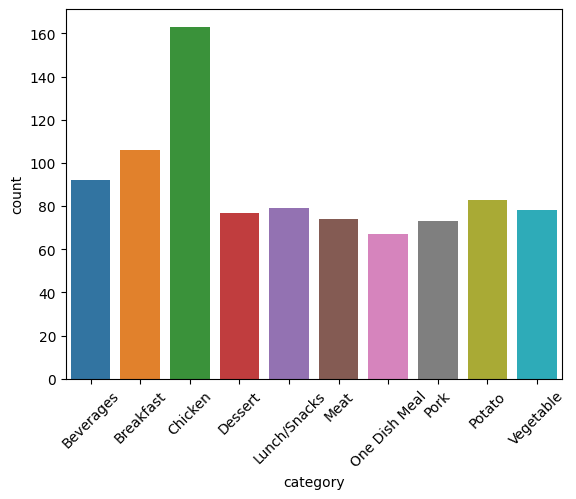

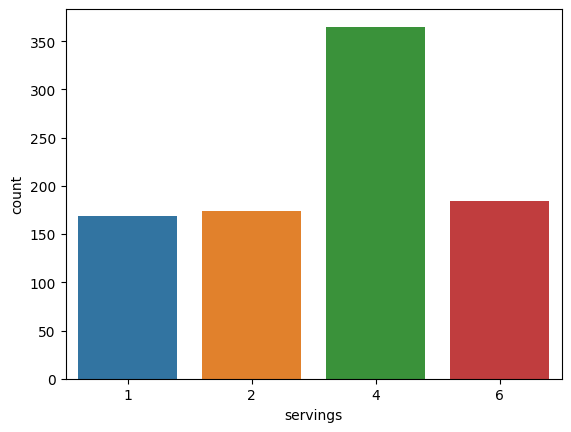

In [28]:
sns.countplot(data =df, x = 'category')
plt.xticks(rotation=45)
plt.show()
sns.countplot(data =df, x = 'servings')
plt.show()

I have visualized how many recipe of each category yielded high and low traffic. Bevareges almost never yield high traffic, but vegtables, potato and pork almost always did. Some other categories are more balanced, but there is clearly a tendency in most of them. We should also note that the 'High' target category is somewhat more numerous, so we should be careful while drawing conlcusions about the more balanced classes, such as desert or Lunch/Snacks.

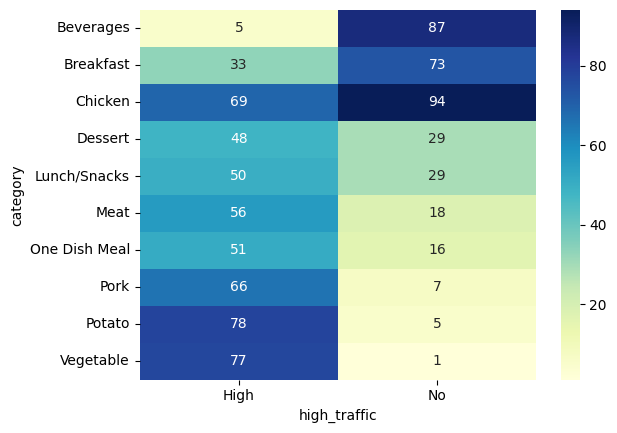

In [24]:




cross_tab = pd.crosstab(df['category'], df['high_traffic'])

# Plot the heatmap
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

# Model fitting and evaluation
For this classification problem, I am going to use a Decision Tree Classifier and a Logistic Regressor. 

Since we are more interested in identifying a few recipes that are guaranteed to generate high traffic, we should most importantly consider specificity. That is what we actually care about based on the business question. Alongside with specificity I will also calculate F1 score and accuracy, to have a better sense of the model's performance.


I chose the following features: calories, carbohydrate, sugar, protein, category, servings. Note that I did not include recipe, as it is just an id. The target variables are in the high_traffic column. 


I preprocessed data: I encoded the categorical features to numerical, I scaled numeric features and split the data into train and test sets, making sure to take into account the small class impalance.

In [234]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])
scaler = MinMaxScaler()
df['calories'] = scaler.fit_transform(df[['calories']])
df['carbohydrate'] = scaler.fit_transform(df[['carbohydrate']])
df['sugar'] = scaler.fit_transform(df[['sugar']])
df['protein'] = scaler.fit_transform(df[['protein']])
X = df[['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings']]
y = df['high_traffic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=4)

Next I have trained and tested the models. On the decision tree I have also perfermed hyperparameter tuning.

In [261]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import numpy as np
np.random.seed(44)


tree = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}
grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)


tree = DecisionTreeClassifier(criterion= 'entropy', max_depth = 5, min_samples_leaf=3, min_samples_split=10)
tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, precision_score
accuracy_tree = accuracy_score(y_test, y_pred)
print("Accuracy tree:", accuracy_tree)

from sklearn.metrics import precision_score


precision_tree = precision_score(y_test, y_pred, pos_label="High")
print("Precision Score Tree:", precision_tree)


f1_tree = f1_score(y_test, y_pred, pos_label="High")
print("F1 Score tree:", f1_tree)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=3)
Accuracy tree: 0.7238805970149254
Precision Score Tree: 0.8071428571428572
F1 Score tree: 0.7533333333333334


In [262]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Accuracy Logreg:", accuracy_logreg)

precision_logreg = precision_score(y_test, y_pred_logreg, pos_label="High")
print("Precision Score Logreg:", precision_logreg)

# Calculate F1 score
f1_logreg = f1_score(y_test, y_pred_logreg, pos_label="High")
print("F1 Score Logreg:", f1_logreg)

Accuracy Logreg: 0.7089552238805971
Precision Score Logreg: 0.7847222222222222
F1 Score Logreg: 0.7434210526315791


The decision tree performs better on all metrics most importantly on the precision.

# Evaluating by business criteria
I consider the Precision score as the KPI since we are mostly interested in making sure that what we identify as positive is actually positive. The target is 80% as it was mentioned by the Product Manager.
The decision tree already performs well enough, 80% of the time the recipes predicted as positive are indeed positive. 
The Decision Tree performs better considering the KPI.

# Recommendtaions

-Increasing the treshold of the model. This means we might loose recipes that could have performed well, but we will be more confident that the recipes we have chosen will actually generate high traffic. Based on the big number of avaliable recipes I would suggest this strategy.

-Deploying the model using an API or web/mobile app

-Collecting more data from the recipe, such as the number of steps in the recipe or the used ingredients or using text vectorization.

-Differentiating between high traffic and traffic. It would be helpful to know the exact amounts of generated traffic, so we could predict the traffic by a regression model. With this we could not only maximize the chance that we find high traffic generating recipes, but we could maximize the actual traffic generated by the website more directly.


